In [1]:
import sys, os

filePath = "F:\\TUDelft\\ResearchAssistant\\research\\code\\RK4_SinDy-main"

sys.path.insert(0, filePath)

In [2]:
import numpy as np
import torch
import os
from scipy.integrate import solve_ivp
from dataclasses import dataclass
import matplotlib.pyplot as plt
import pysindy as ps
import Dictionary.polynomial_library_torch as  pl_torch
from Functions.utils import printing_learned_model
from Functions.modules import coeffs_dictionary
from Functions.models import FHN_model
from Functions.learning_models import learning_sparse_model
from IPython.utils.io import Tee
from contextlib import closing
import tikzplotlib

In [4]:
randSeed = 42

torch.manual_seed(randSeed)
np.random.seed(seed=randSeed)

In [5]:
@dataclass
class parameters:
    bs: int = 8
    num_epochs: int = 750
    num_iter = 5
    lr: float = 1e-2
    save_model_path: str = './Results/FHN/'
    weightdecay: float =0e-3
    NumInitial: int = 1
    dim_x: int = 2
    timefinal: float = 600.0
    timestep: float = 5e-2
    normalize: bool = True
    tol_coeffs: float = 1e-2
    polyorder: int = 3
    tikz_save: bool = False

Params = parameters()
os.makedirs(os.path.dirname(Params.save_model_path), exist_ok=True)

In [6]:
dynModel = FHN_model

# Define timesteps, lr, and epochs
timesteps = [1e-1,2.5e-1,5e-1,7.5e-1]
learningrates = 5e-2*np.asarray([5.,1.,1.,0.5])
epochs = [1000,1000,1000,1000]

In [7]:
stepInd = 0

Params.timestep = timesteps[stepInd]
Params.lr = learningrates[stepInd]
Params.num_epochs = epochs[stepInd]

In [8]:
with closing(Tee(Params.save_model_path + "FHN_DiscoveredModels.log", "a+", channel="stdout")) as outputstream:
    # printing of the learned sparse models in a file
    print('*'*100)
    print('*'*10 + ' DATA COLLECTED AT TIME STEPPING {0:.3f} '.format(timesteps[stepInd]) + '*'*10)


****************************************************************************************************
********** DATA COLLECTED AT TIME STEPPING 0.100 **********


In [9]:
ts = np.arange(0,Params.timefinal,Params.timestep)
    # Initial condition and simulation time
x0 = [0,0]
sol = solve_ivp(lambda t, x: dynModel(x, t), 
            [ts[0], ts[-1]], x0, t_eval=ts)
# x = sol
x = np.transpose(sol.y).reshape(1,-1,Params.dim_x)

x_original = x.copy()

# Define dataloaders
train_dset = list(zip(torch.tensor(x).float(),ts.reshape(1,-1,1)))
train_dl = torch.utils.data.DataLoader(train_dset, batch_size =Params.bs)
dataloaders = {'train': train_dl}


# defining library
funs_dictionary = pl_torch.PolynomialLibrary(degree = Params.polyorder)
funs_dictionary.fit(x[0])
funs_dictionary_size = funs_dictionary.transform(x[0]).shape[1]


Coeffs = coeffs_dictionary(funs_dictionary_size,Params.dim_x)

# Learning Coefficients
Coeffs, _ = learning_sparse_model(funs_dictionary, Coeffs, dataloaders, Params,lr_reduction = 5)
Learned_Coeffs = Coeffs.linear.weight.detach().clone().t().numpy()
        

 [Iter 1/5] [Epoch 1000/1000] [Training loss: 3.92e-06] [Learning rate: 2.50e-01]

tensor([[ 5.0356e-01,  9.8815e-01, -9.9282e-01, -2.3411e-03, -1.2001e-02,
         -1.8359e-02, -3.2968e-01,  6.1850e-03,  9.0853e-03,  1.0824e-02],
        [ 3.2107e-02,  3.9119e-02, -2.7857e-02, -4.2895e-04, -1.1529e-03,
         -1.4880e-03,  5.3200e-04,  4.9228e-04,  1.3100e-03,  5.6395e-04]])

Error in coeffs due to truncation: 0.009085339494049549
Printing coeffs after 1 iter after truncation
Parameter containing:
tensor([[ 0.5036,  0.9881, -0.9928, -0.0000, -0.0120, -0.0184, -0.3297,  0.0000,
          0.0000,  0.0108],
        [ 0.0321,  0.0391, -0.0279, -0.0000, -0.0000, -0.0000,  0.0000,  0.0000,
          0.0000,  0.0000]], requires_grad=True)

 [Iter 2/5] [Epoch 1000/1000] [Training loss: 5.82e-07] [Learning rate: 5.00e-02]

tensor([[ 4.9904e-01,  9.9743e-01, -9.9745e-01, -0.0000e+00, -5.8131e-04,
          2.6490e-04, -3.3234e-01,  0.0000e+00,  0.0000e+00, -5.2038e-04],
        [ 3.1951e-02,

In [10]:
# Fit a model using Sindy
threshold = Params.tol_coeffs

model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold),
    feature_library=ps.PolynomialLibrary(degree = Params.polyorder),
)
model.fit(x.reshape(-1,2), t=Params.timestep);


# Simulate all identified model
f1 = lambda z: (funs_dictionary.transform(np.expand_dims(z, axis=0))@Learned_Coeffs).reshape(-1,)
learnt_deri = lambda z,t: np.array(f1(z))

x0 = np.array(x0)

ts_refine = np.arange(0,Params.timefinal,1e-2)

sol = solve_ivp(lambda t, x: dynModel(x, t), 
            [ts_refine[0], ts_refine[-1]], x0, t_eval=ts_refine)
# x = sol
x_refine = np.transpose(sol.y).reshape(1,-1,Params.dim_x)


x_sindy = model.simulate(x0, ts_refine).reshape(1,-1,Params.dim_x)

sol_learnt = solve_ivp(lambda t, x: learnt_deri(x, t), 
            [ts_refine[0], ts_refine[-1]], x0, t_eval=ts_refine)
x_learnt = np.transpose(sol_learnt.y).reshape(1,-1,Params.dim_x)
   

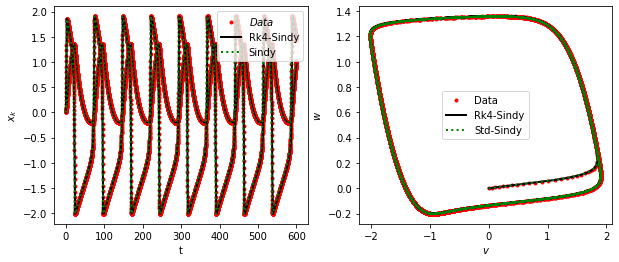

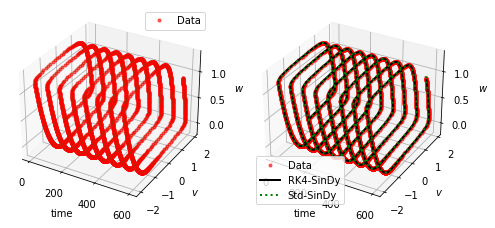

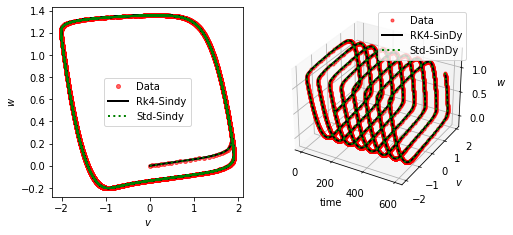

In [11]:
plot_kws = dict(linewidth=2)
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(ts, x[0,:, 0], "ro",markersize=3, label="$Data$", **plot_kws)
axs[0].plot(ts, x[0,:, 1], "ro", markersize=3, **plot_kws)
axs[0].plot(ts_refine, x_learnt[0,:, 0], "k-", label="Rk4-Sindy", **plot_kws)
axs[0].plot(ts_refine, x_learnt[0,:, 1], "k-")
axs[0].plot(ts_refine, x_sindy[0,:, 0], "g:", label="Sindy", **plot_kws)
axs[0].plot(ts_refine, x_sindy[0,:, 1], "g:")

axs[0].legend()
axs[0].set(xlabel="t", ylabel="$x_k$")

axs[1].plot(x_original[0,:, 0], x_original[0,:, 1], "ro",markersize=3, label="Data", **plot_kws)
axs[1].plot(x_learnt[0,:, 0], x_learnt[0,:, 1], "k-", markersize=3, label="Rk4-Sindy", **plot_kws)
axs[1].plot(x_sindy[0,:, 0], x_sindy[0,:, 1], "g:", label="Std-Sindy", **plot_kws)
axs[1].legend()

axs[1].set(xlabel="$v$", ylabel="$w$")

if Params.tikz_save:
    tikzplotlib.save(Params.save_model_path + "FHN_timestep_{}.tex".format(Params.timestep))
plt.show()
fig.savefig(Params.save_model_path + "FHN_timestep_{}.pdf".format(Params.timestep), bbox_inches = 'tight',pad_inches = 0)


fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(121, projection="3d")
ax.plot(
ts,
x[0,:, 0],
x[0,:, 1], 
"ro",markersize=3,label="Data",alpha = 0.6,
)
ax.plot(
ts_refine, 
x_refine[0,:, 0],
x_refine[0,:, 1],"g",linewidth =.2,
)
ax.set(xlabel="time", ylabel="$v$",zlabel="$w$")
ax.legend()


ax = fig.add_subplot(122, projection="3d")
ax.plot(
ts,
x[0,:, 0],
x[0,:, 1], 
"ro",markersize=3,label="Data",alpha = 0.6,
)
ax.plot(
ts_refine[:], 
x_learnt[0,:, 0],
x_learnt[0,:, 1],"k-",label="RK4-SinDy", **plot_kws
)
ax.plot(
ts_refine, 
x_sindy[0,:, 0],
x_sindy[0,:, 1],"g:",label="Std-SinDy", **plot_kws
)
ax.set(xlabel="time", ylabel="$v$",zlabel="$w$")

ax.legend()

if Params.tikz_save:
    tikzplotlib.save(Params.save_model_path + "FHN_3Dplot_timestep_{}.tex".format(Params.timestep))
plt.show()
fig.savefig(Params.save_model_path + "FHN_3Dplot_timestep_{}.pdf".format(Params.timestep), bbox_inches = 'tight',pad_inches = 0)


fig = plt.figure(figsize=(7.5, 3.5))
ax = fig.add_subplot(121)

ax.plot(x_original[0,:, 0], x_original[0,:, 1], "ro",markersize=4, alpha = 0.6,label="Data", **plot_kws)
ax.plot(x_learnt[0,:, 0], x_learnt[0,:, 1], "k-", markersize=4, label="Rk4-Sindy", **plot_kws)
ax.plot(x_sindy[0,:, 0], x_sindy[0,:, 1], "g:", label="Std-Sindy", **plot_kws)
ax.legend()
ax.set(xlabel="$v$", ylabel="$w$")
    

ax = fig.add_subplot(122, projection="3d")
ax.plot(
ts[:],
x[0,:, 0],
x[0,:, 1], 
"ro",markersize=3,label = "Data",alpha = 0.6,
)
ax.plot(
ts_refine[:], 
x_learnt[0,:, 0],
x_learnt[0,:, 1],"k-",label="RK4-SinDy", **plot_kws
)
ax.plot(
ts_refine, 
x_sindy[0,:, 0],
x_sindy[0,:, 1],"g:",label="Std-SinDy", **plot_kws
)
ax.set(xlabel="time", ylabel="$v$",zlabel="$w$")


ax.legend()

if Params.tikz_save:
    tikzplotlib.save(Params.save_model_path + "FHN_23Dplot_timestep_{}.tex".format(Params.timestep))
plt.show()
fig.savefig(Params.save_model_path + "FHN_23Dplot_timestep_{}.pdf".format(Params.timestep), bbox_inches = 'tight',pad_inches = 0)


In [12]:
with closing(Tee(Params.save_model_path + "FHN_DiscoveredModels.log", "a+", channel="stdout")) as outputstream:
    # printing of the learned sparse models in a file
    print('\n')
    print('='*50)
    print('RK4 Inspired Methods Sparse Identification')
    printing_learned_model(Learned_Coeffs,funs_dictionary.get_feature_names())
    print('='*50)
    print('Sindy Approach')
    model.print()
    print('='*50)



RK4 Inspired Methods Sparse Identification
dx0'= 0.499 1 + 0.998 x0 + -0.998 x1 + -0.333 x0^3 
dx1'= 0.032 1 + 0.040 x0 + -0.028 x1 
Sindy Approach
(x0)' = 0.498 1 + 0.996 x0 + -0.996 x1 + -0.332 x0^3
(x1)' = 0.032 1 + 0.040 x0 + -0.028 x1
